# LSTM Autoencoder for Dengue Outbreak Detection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector


2025-04-28 14:15:58.405138: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 14:15:58.406166: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 14:15:58.411567: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 14:15:58.425360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745849758.447965 1169327 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745849758.45

In [51]:
df = pd.read_csv('dengue-2013-2023.csv')

print(df.head())

  Disease  Year PROVINCE  Week_no  Count
0  Dengue  2013  Bangkok        1    351
1  Dengue  2013  Bangkok        2    399
2  Dengue  2013  Bangkok        3    300
3  Dengue  2013  Bangkok        4    280
4  Dengue  2013  Bangkok        5    262


### Preprocessing

In [52]:
# Only keep relevant columns
df = df[['Year', 'PROVINCE', 'Week_no', 'Count']]

In [53]:
# Visualize data by province
# sns.set(style="whitegrid")
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=df, x='Week_no', y='Count', hue='PROVINCE')
# plt.title('Dengue Cases by Province')
# plt.xlabel('Week Number')
# plt.ylabel('Count')
# plt.legend(title='Province')
# plt.show()

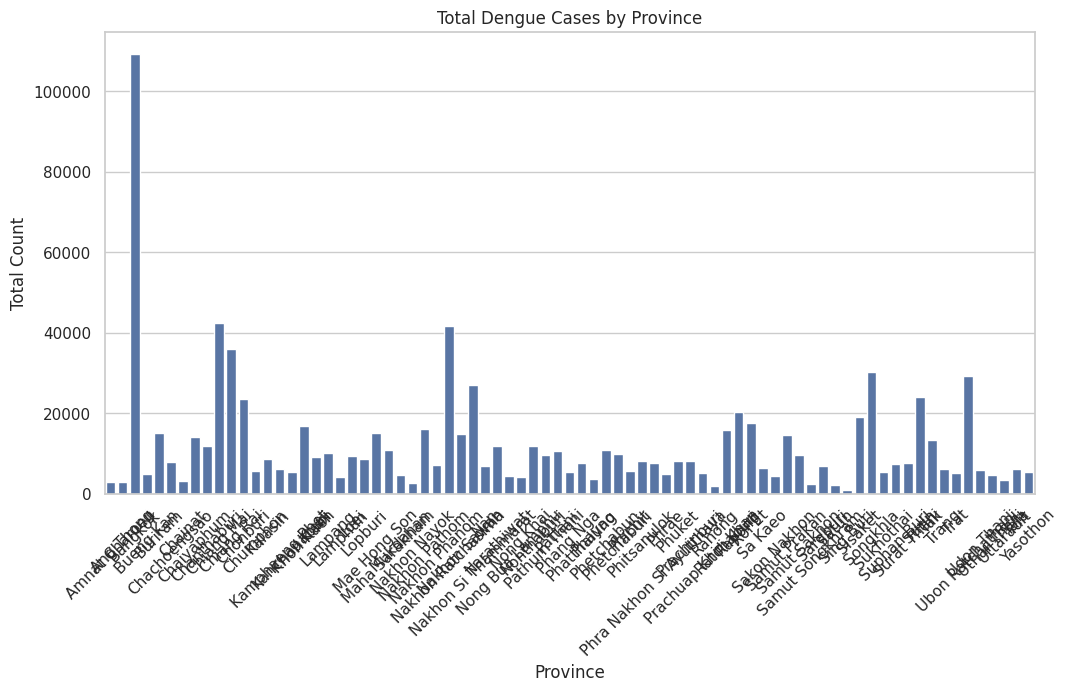

In [54]:
# Count all cases by province
df_province = df.groupby('PROVINCE')['Count'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_province, x='PROVINCE', y='Count')
plt.title('Total Dengue Cases by Province')
plt.xlabel('Province')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.show()

In [55]:
# Print the most affected province
most_affected_province = df_province.loc[df_province['Count'].idxmax()]
print(f"Most affected province: {most_affected_province['PROVINCE']} with {most_affected_province['Count']} cases.")

Most affected province: Bangkok with 109244 cases.


In [56]:
# OPTIONAL: Filter a specific province if you want per-province model
province = 'Bangkok'
df = df[df['PROVINCE'] == province]

In [57]:
# Sort by year and week
df = df.sort_values(by=['Year', 'Week_no']).reset_index(drop=True)

In [58]:
# Sort by year and week
df = df.sort_values(by=['Year', 'Week_no']).reset_index(drop=True)

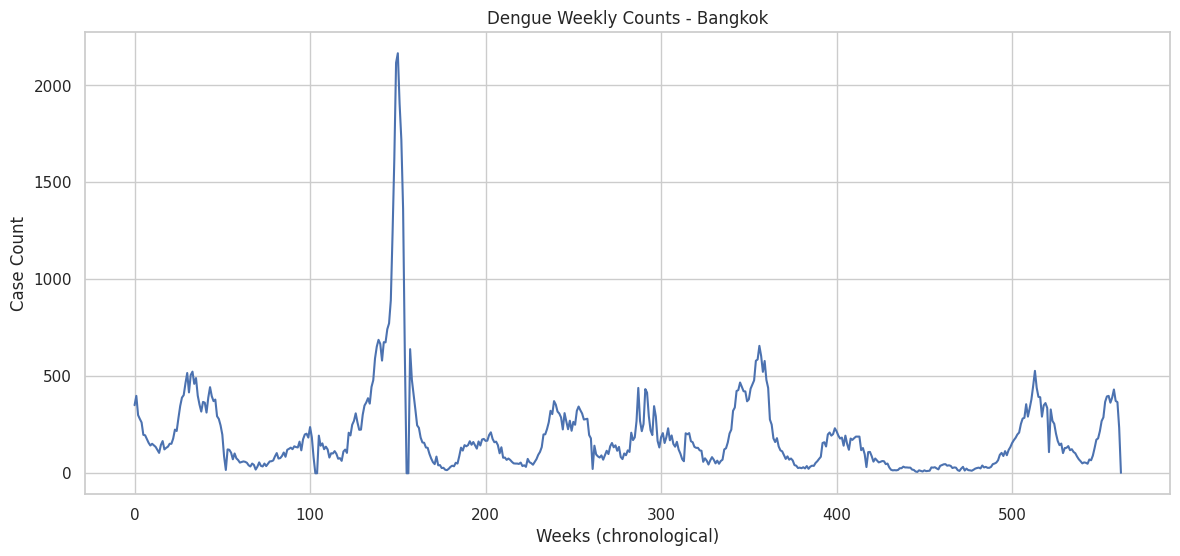

In [59]:
# 4. EDA - Quick Visualization
plt.figure(figsize=(14,6))
plt.plot(df['Count'].values)
plt.title(f'Dengue Weekly Counts - {province}')
plt.xlabel('Weeks (chronological)')
plt.ylabel('Case Count')
plt.show()

In [60]:
# 5. Prepare Data for LSTM Autoencoder
scaler = MinMaxScaler()
count_scaled = scaler.fit_transform(df[['Count']])

In [61]:
# Create sequences
def create_sequences(data, time_steps=8):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i+time_steps])
    return np.array(sequences)

In [62]:
TIME_STEPS = 12
X = create_sequences(count_scaled, TIME_STEPS)

print(f"Shape of input sequences: {X.shape}")

Shape of input sequences: (551, 12, 1)


In [63]:
# Split into train and test
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

In [64]:
# 6. Build LSTM Autoencoder
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(64, activation='relu')(inputs)
    decoded = RepeatVector(input_shape[0])(encoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(1, activation='sigmoid', return_sequences=True)(decoded)
    
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


In [65]:
model = build_model((TIME_STEPS, 1))
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 12, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 12, 1)          │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,184 (196.03 KB)

 Trainable params: 50,184 (196.03 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# 7. Train the Model
history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - loss: 0.0858 - val_loss: 0.1063
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0821 - val_loss: 0.1008
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0772 - val_loss: 0.0932
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0705 - val_loss: 0.0818
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0608 - val_loss: 0.0642
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0472 - val_loss: 0.0394
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0323 - val_loss: 0.0183
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0253 - val_loss: 0.0099
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0235 - val_loss: 0.0062
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0228 - val_loss: 0.0044
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0226 - val_loss: 0.0035
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0226 - val_loss: 0.0030


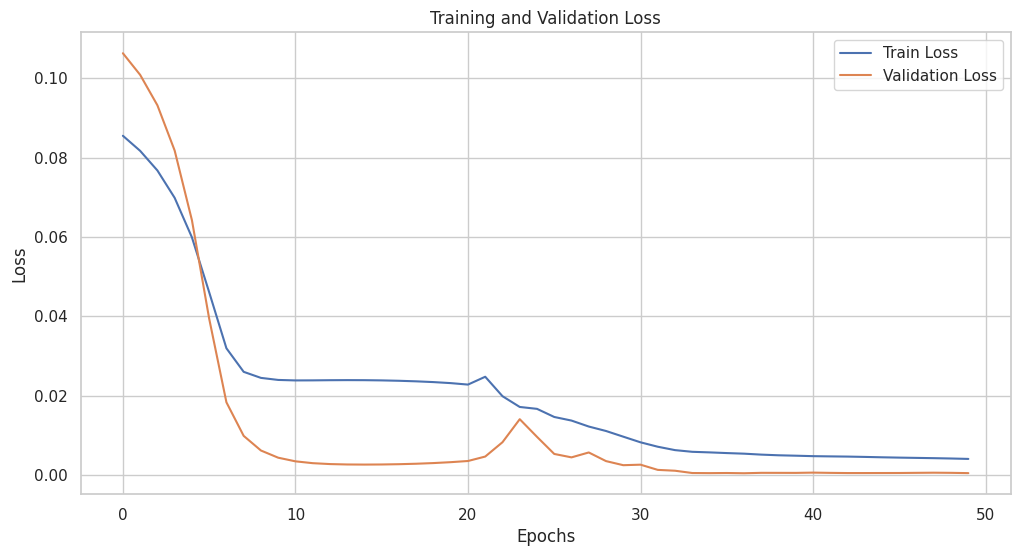

In [67]:
# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


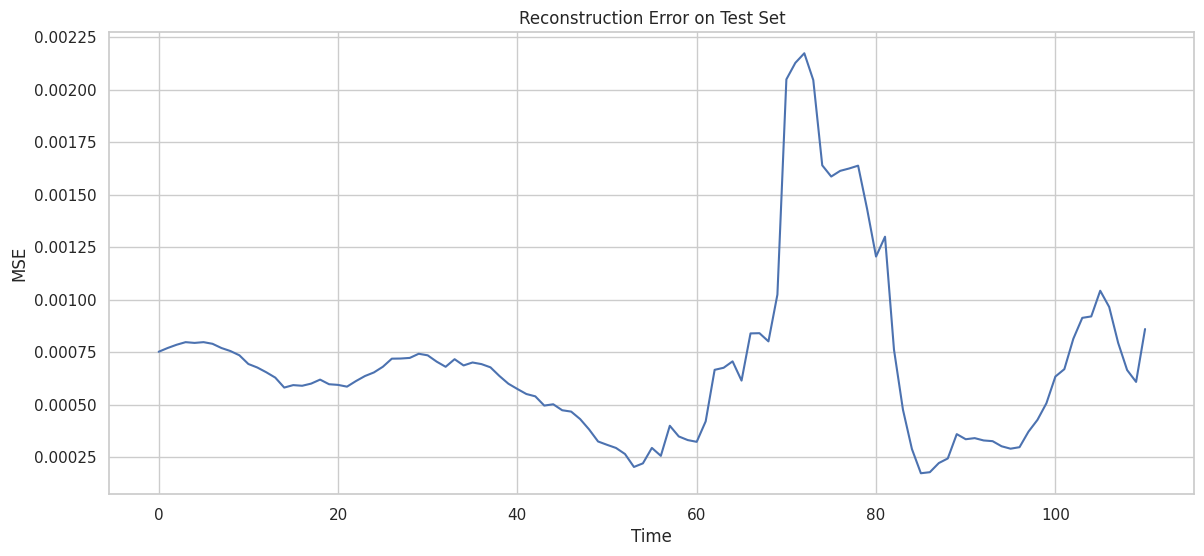

In [68]:
# 9. Evaluate: Reconstruction Errors
X_pred = model.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1,2))

# Plot MSE
plt.figure(figsize=(14,6))
plt.plot(mse)
plt.title('Reconstruction Error on Test Set')
plt.ylabel('MSE')
plt.xlabel('Time')
plt.show()


### Static Threshold

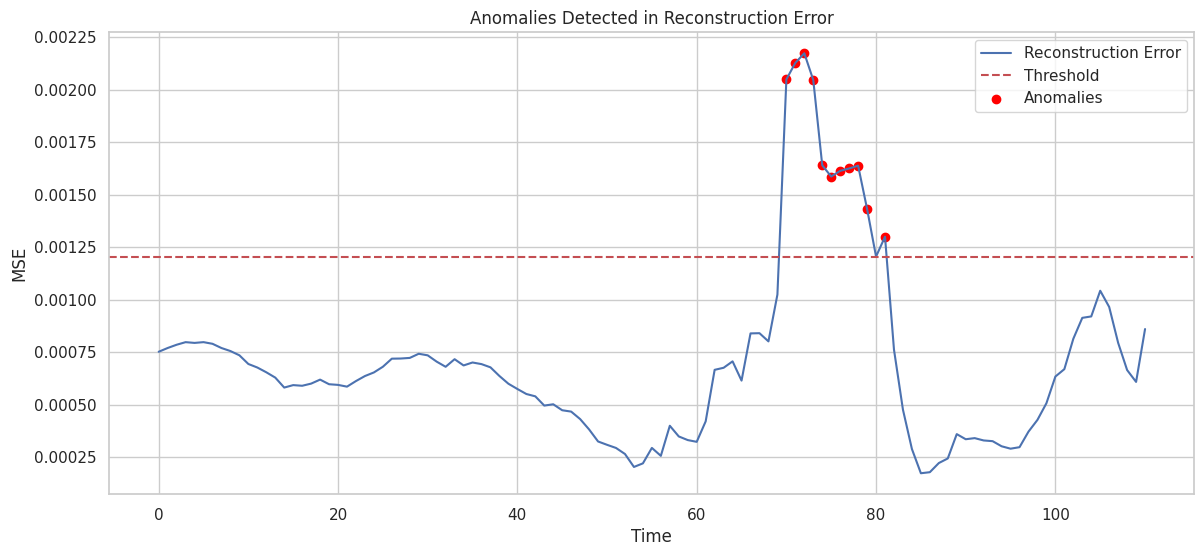

In [74]:
# 10. Set Threshold and Detect Anomalies
threshold = np.percentile(mse, 90)  # Top 10% MSE treated as anomaly

anomalies = mse > threshold

# Plot detected anomalies 
plt.figure(figsize=(14,6))
plt.plot(mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies)[0], mse[anomalies], color='red', label='Anomalies')
plt.title('Anomalies Detected in Reconstruction Error')
plt.ylabel('MSE')
plt.xlabel('Time')
plt.legend()
plt.show()


### Dynamic Threshold
Instead of static thresholds (like 95th percentile), we'll use a dynamic thresholding method based on the moving average + standard deviation.

This way:
- The threshold can adapt based on local data behavior.
- It handles seasonality and gradual changes better.

#### Plan
- After computing the reconstruction error (MSE) over time,
- We'll apply a moving average + k times standard deviation window.
- If error > (moving average + k×std), we flag it as an anomaly (outbreak).

In [75]:
import scipy.stats

# --- 2. Dynamic Thresholding based on Moving Average
def dynamic_threshold(mse_errors, window_size=10, sigma=3):
    """
    Compute dynamic threshold using moving average and moving std deviation
    Args:
        mse_errors (np.array): Reconstruction errors
        window_size (int): size of moving window
        sigma (float): number of std deviations above mean considered anomaly
    Returns:
        thresholds (np.array): Threshold per point
    """
    thresholds = []
    for i in range(len(mse_errors)):
        if i < window_size:
            window = mse_errors[:i+1]
        else:
            window = mse_errors[i-window_size:i]
        
        mean = np.mean(window)
        std = np.std(window)
        thresholds.append(mean + sigma * std)
    return np.array(thresholds)

In [82]:
# Apply dynamic threshold
window_size = 14

# Higher sigma → fewer, bigger anomalies.
# Lower sigma → more sensitive, more anomalies.
sigma = 3.5

dynamic_thresh = dynamic_threshold(mse, window_size, sigma)


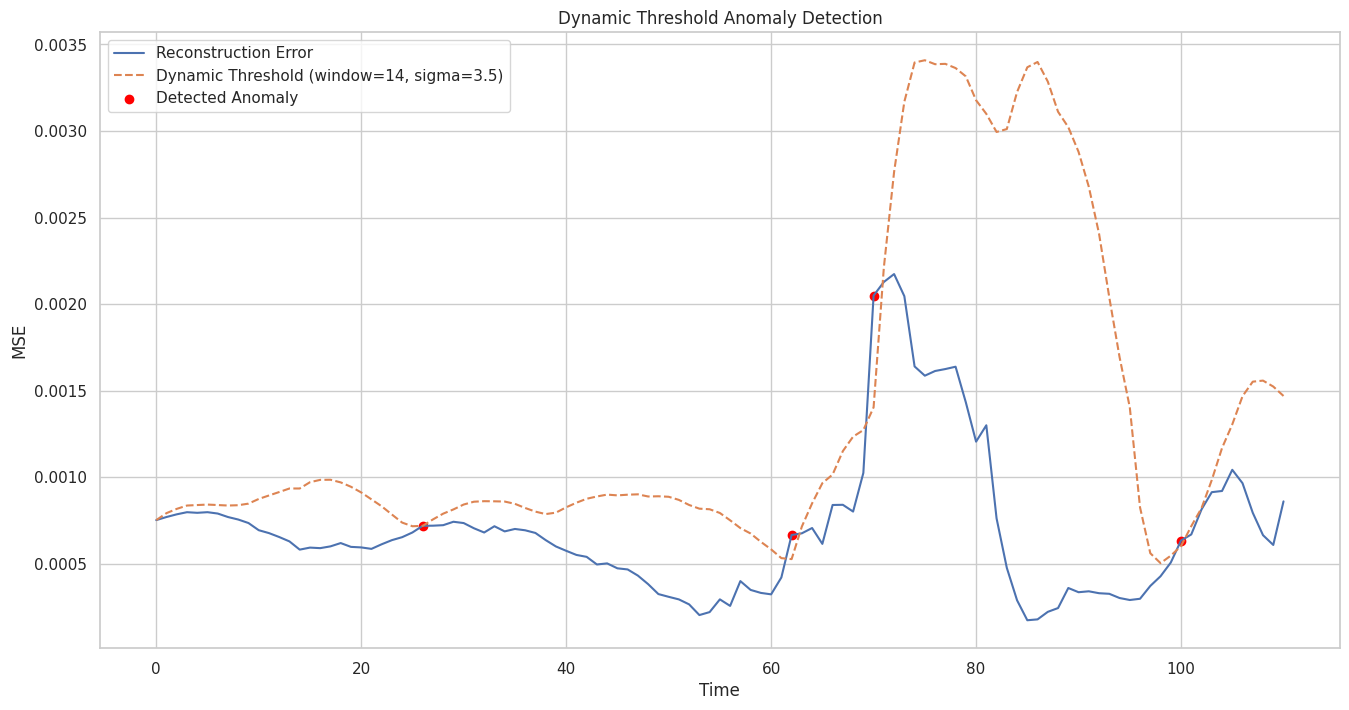

In [83]:
anomalies = mse > dynamic_thresh

# Plotting Results
plt.figure(figsize=(16,8))
plt.plot(mse, label='Reconstruction Error')
plt.plot(dynamic_thresh, label=f'Dynamic Threshold (window={window_size}, sigma={sigma})', linestyle='--')
plt.scatter(np.where(anomalies)[0], mse[anomalies], color='red', label='Detected Anomaly')
plt.legend()
plt.title('Dynamic Threshold Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.show()


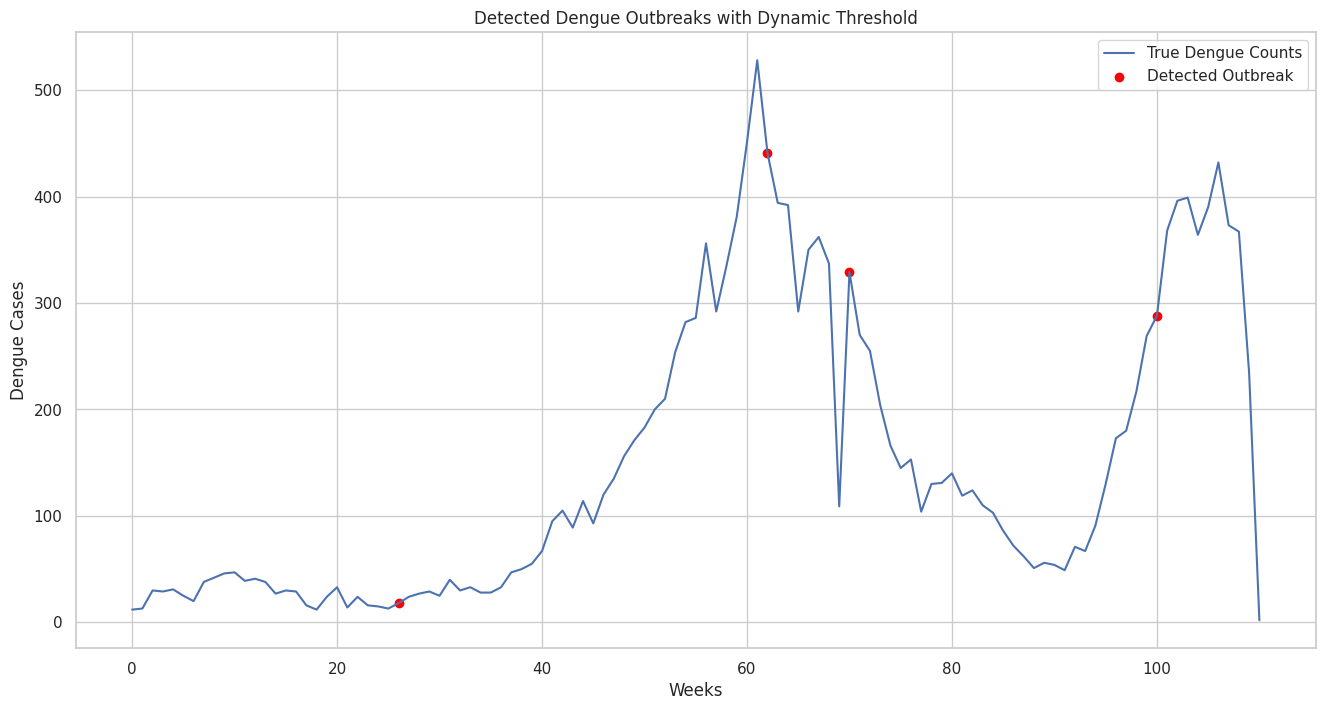

In [84]:
# --- 5. Plot Anomalies on Real Case Counts
plt.figure(figsize=(16,8))
plt.plot(df.iloc[-len(mse):]['Count'].values, label='True Dengue Counts')
plt.scatter(
    np.where(anomalies)[0],
    df.iloc[-len(mse):]['Count'].values[anomalies],
    color='red',
    label='Detected Outbreak'
)
plt.legend()
plt.title('Detected Dengue Outbreaks with Dynamic Threshold')
plt.xlabel('Weeks')
plt.ylabel('Dengue Cases')
plt.show()


### References
Here are the reference to read:
- https://pmc.ncbi.nlm.nih.gov/articles/PMC10452936/ 
- https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/manuscript/06.time-series-anomaly-ecg.md 